# Convolución y Correlación

**Curso:** Procesamiento Digital de Señales (PDS)

**Semestre:** 2025 - II 
---

Objetivos de aprendizaje:

- Entender y aplicar las definiciones matemáticas de convolución y correlación en señales discretas.
- Implementar métodos directos y basados en FFT y comparar su comportamiento numérico y de rendimiento.
- Identificar efectos prácticos como aliasing en convolución circular y su corrección por padding o esquemas por bloques.
- Interpretar resultados experimentales y documentar observaciones con gráficos y análisis.

### Instalación de librerías

Instala las dependencias si aún no lo has hecho (hay un `requirements.txt` en la raíz):

```bash
pip install -r requirements.txt
```

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from labs import convolucion_correlacion as cc

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,4)

### Convolución lineal y su interpretación

La convolución discreta lineal entre dos señales $x[n]$ y $h[n]$ se define como:

$$
y[n] = (x * h)[n] = \sum_{k=-\infty}^{\infty} x[k]\; h[n-k]
$$

Interpretación y comentarios:

- Visualización: para cada $k$, tomamos $h[n]$ desplazada por $k$ y la escalamos por $x[k]$; la suma de todas esas contribuciones da $y[n]$.
- Propiedades importantes: conmutativa $(x*h = h*x)$, asociativa $((x*h)*g = x*(h*g))$ y distributiva sobre la suma.
- Implementación numérica: si $x$ tiene longitud $N_{\mathrm{x}}$ y $h$ tiene longitud $N_{\mathrm{h}}$, la salida "full" tiene longitud $N_{\mathrm{x}}+N_{\mathrm{h}}-1$.

Para señales largas se prefiere la convolución por FFT usando zero-padding hasta al menos $N_{\mathrm{x}}+N_{\mathrm{h}}-1$.

Notas prácticas:
- Si $h[n]$ es la respuesta al impulso de un sistema lineal e invariante en el tiempo (LTI), entonces $y[n]$ es la salida del sistema para la entrada $x[n]$.
- La convolución en el dominio del tiempo equivale a multiplicación en el dominio de la frecuencia (DFT/FFT): $\mathrm{DFT}\{x*h\} = \mathrm{DFT}\{x\} \cdot \mathrm{DFT}\{h\}$.

### Teoría ampliada: Convolución circular y aliasing

Para secuencias definidas en el grupo cíclico de longitud $N$, la convolución circular se define como:

$$
y[n] = \sum_{k=0}^{N-1} x[k]\; h[(n-k)\ \mathrm{mod}\ N], \qquad n=0,\dots,N-1.
$$

Comentarios y consecuencias:

- La DFT asume que las señales son periódicas con periodo $N$; por eso la operación natural en frecuencia corresponde a una convolución circular en tiempo.
- Si queremos recuperar la convolución lineal mediante FFT debemos aplicar zero-padding: elegir una longitud $N$ tal que $N \ge N_{\mathrm{x}}+N_{\mathrm{h}}-1$.

De lo contrario, los términos que caen fuera del rango se "pliegan" (alias) dentro del intervalo y producen resultados incorrectos para la convolución lineal.

### Teoría ampliada: Correlación cruzada

La correlación cruzada entre $x[n]$ y $y[n]$ (forma "full") puede escribirse de forma que no aparezca conjugado (esta es la forma natural para señales reales):

$$
r_{xy}[\ell] = \sum_{n} x[n+\ell]\; y[n],
$$

Sin embargo, en el tratamiento general para señales complejas es habitual incluir el conjugado de una de las señales para que la correlación mida adecuadamente la similitud en magnitud y fase:

$$
r_{xy}[\ell] = \sum_{n} x[n+\ell]\; \overline{y[n]},\quad\text{(convención para señales complejas)}
$$

Otra forma equivalente (cambio de variable) es

$$
r_{xy}[\ell] = \sum_{n} x[n]\; \overline{y[n-\ell]}.
$$

Nota: para señales reales $\overline{y[n]}=y[n]$, por lo que ambas expresiones coinciden con la forma sin conjugado. Por eso algunas presentaciones (centradas en señales reales) no mencionan explícitamente el conjugado y pueden dar la impresión de que "la correlación nunca usa conjugada". En textos de procesamiento de señales y en aplicaciones con señales complejas (por ejemplo, en comunicaciones) sí es usual la versión con conjugado.

Convención de lags / índices (muy importante): para el modo "full" la salida tiene longitud $N_x+N_y-1$. Si almacenamos el resultado en un array "r" con índices de 0 a $N_x+N_y-2$, el lag asociado al índice i es:

$$
\ell = i - (N_y - 1),\quad\text{con }\ell \in [-(N_y-1),\dots,N_x-1].
$$

Relación con la convolución: si definimos $y^*[n] = \overline{y[-n]}$, entonces (usando la versión con conjugado)

$$
r_{xy}[\ell] = (x * y^*)[\ell],
$$

Esto explica por qué, para calcular la correlación mediante una convolución numérica, se toma la segunda señal invertida y conjugada (por ejemplo, `y_rev = np.conjugate(y[::-1])` y luego `linear_convolution(x, y_rev)`); para señales reales la conjugación no modifica el resultado.

Interpretación: $r_{xy}[\ell]$ mide la similitud entre $x[n]$ y una versión desplazada de $y[n]$. El valor de $\ell$ que maximiza $|r_{xy}[\ell]|$ indica el mejor alineamiento (retardo) entre las señales).

Notas numéricas y prácticas:
- La correlación puede calcularse de forma eficiente con FFT: $\mathrm{DFT}\{r_{xy}\} = \mathrm{DFT}\{x\} \cdot \overline{\mathrm{DFT}\{y\}}$ (con el zero-padding adecuado para evitar aliasing).
- Atención a las convenciones: algunas bibliotecas o textos adoptan la forma alternativa con signo cambiado en el argumento del desplazamiento; por eso es recomendable documentar la convención usada y mostrar el vector de lags al plotear/analizar los resultados.

### Aclaración: correlación vs convolución (qué se invierte y qué se conjuga)

Importante: en la definición de correlación cruzada no se invierten las señales (como sí se hace en la convolución). La correlación mide la similitud entre una señal y otra desplazada; según la convención elegida puede aparecer un conjugado sobre una de las señales si se trata de señales complejas.

- Correlación (una convención):
  $$r_{xy}[\ell] = \sum_n x[n+\ell] \; \overline{y[n]}$$
  aquí NO hay inversión de índices en y (solo desplazamiento). Si las señales son reales el conjugado no cambia nada.
- Convolución:
  $$y[n] = (x * h)[n] = \sum_k x[k]\; h[n-k]$$
  en la implementación como correlación-vía-convolución se usa $y^*[n]=\overline{y[-n]}$ (inversión + conjugado) para convertir la correlación en una convolución con esa señal invertida y conjugada.

### Ejemplo 1: Convolución lineal directa vs FFT
Generamos dos señales cortas y comparamos métodos.

y_direct = [1.   2.5  4.25 4.   2.75 1.   0.25]
y_fft    = [1.   2.5  4.25 4.   2.75 1.   0.25]


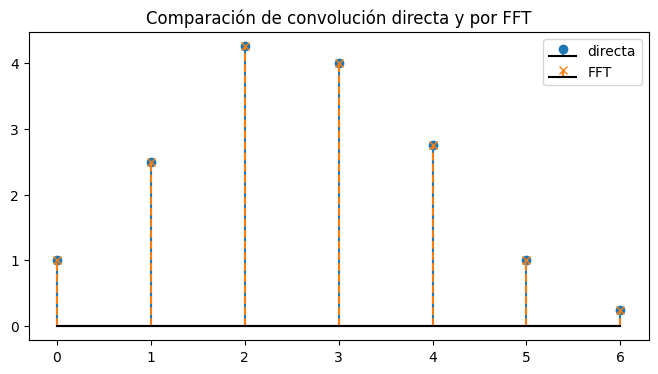

In [114]:
x = np.array([1,2,3,2,1])
h = np.array([1,0.5,0.25])
y_direct = cc.linear_convolution(x,h)
y_fft = cc.conv_via_fft(x,h)
print('y_direct =', y_direct)
print('y_fft    =', np.round(y_fft,6))

plt.stem(y_direct, linefmt='C0-', markerfmt='C0o', basefmt='k-')
plt.stem(y_fft, linefmt='C1--', markerfmt='C1x', basefmt='k-')
plt.legend(['directa','FFT'])
plt.title('Comparación de convolución directa y por FFT')
plt.show()

### Ejemplo 2: Convolución circular
Comparar convolución circular con la lineal y observar aliasing cuando no se hace zero-padding.

circular (N=max(len)) = [5. 3. 5. 7.]
lineal = [1 3 5 7 4 0 0]


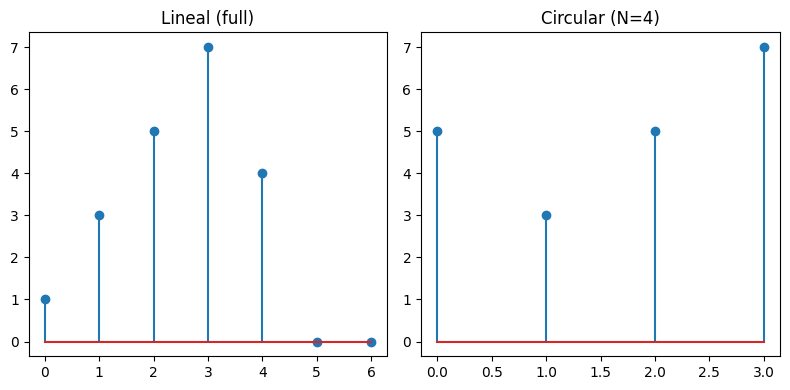

In [36]:
x = np.array([1,2,3,4])
h = np.array([1,1,0,0])
ycirc = cc.circular_convolution(x,h)
ylineal = cc.linear_convolution(x,h)
print('circular (N=max(len)) =', np.round(ycirc,6))
print('lineal =', ylineal)
plt.subplot(1,2,1)
plt.stem(ylineal); plt.title('Lineal (full)')
plt.subplot(1,2,2)
plt.stem(ycirc); plt.title('Circular (N=4)')
plt.tight_layout(); plt.show()

x = [1 2 3 4]
h = [1 1 0 0]
N = 4
circular (N=max) = [5. 3. 5. 7.]
lineal (full)    = [1 3 5 7 4 0 0]
DFT padded (Npad) = [1.00000000e+00 3.00000000e+00 5.00000000e+00 7.00000000e+00
 4.00000000e+00 5.07530526e-16 5.07530526e-16]
mapping for n=0 (k -> (0-k)%N) = [(0, 0), (1, 3), (2, 2), (3, 1)]


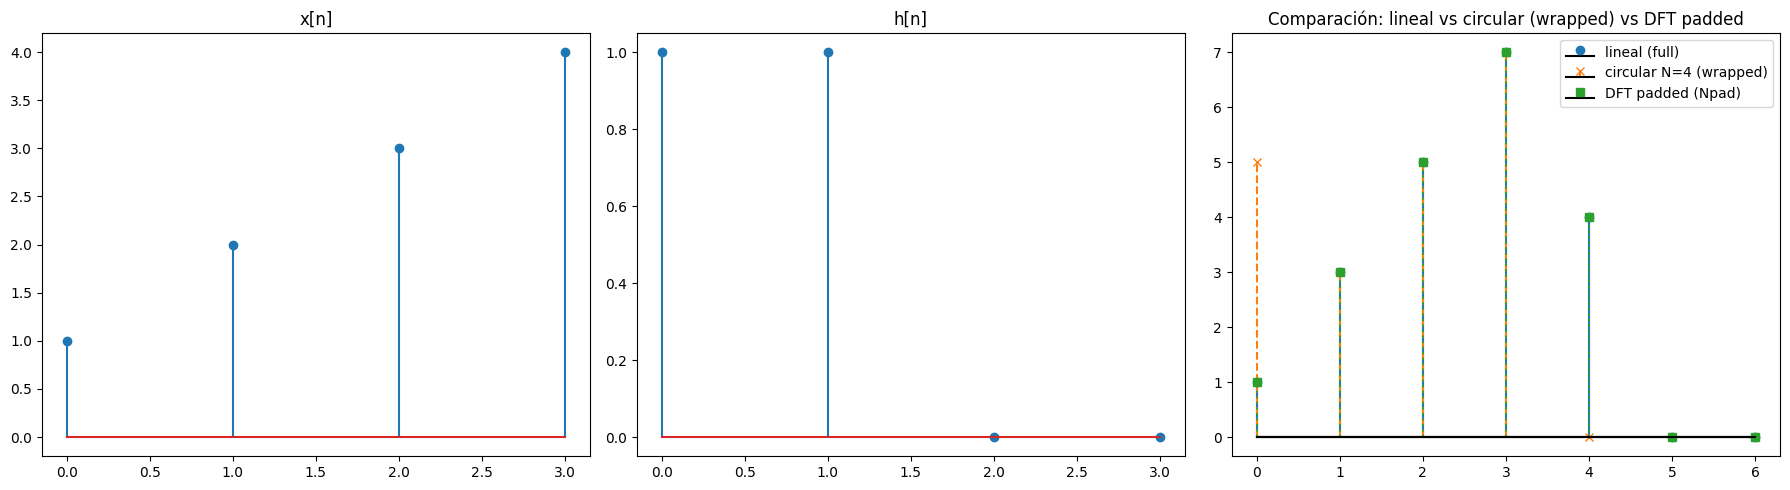

In [42]:
x = np.array([1,2,3,4])
h = np.array([1,1,0,0])
N = max(x.size, h.size)
ycirc = cc.circular_convolution(x, h)
ylineal = cc.linear_convolution(x, h)

Npad = x.size + h.size - 1
X = np.fft.fft(x, Npad)
H = np.fft.fft(h, Npad)
y_pad = np.fft.ifft(X * H)[:Npad]

mapping = [(k, (0 - k) % N) for k in range(N)]
print('x =', x)
print('h =', h)
print('N =', N)
print('circular (N=max) =', ycirc)
print('lineal (full)    =', ylineal)
print('DFT padded (Npad) =', np.real_if_close(y_pad))
print('mapping for n=0 (k -> (0-k)%N) =', mapping)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.stem(x); plt.title('x[n]')
plt.subplot(1,3,2)
plt.stem(h); plt.title('h[n]')
plt.subplot(1,3,3)

plt.stem(range(ylineal.size), ylineal, linefmt='C0-', markerfmt='C0o', basefmt='k-')

ycirc_padded = np.concatenate([ycirc, np.zeros(ylineal.size - ycirc.size)])
plt.stem(range(ycirc_padded.size), ycirc_padded, linefmt='C1--', markerfmt='C1x', basefmt='k-')
plt.stem(range(y_pad.size), np.real_if_close(y_pad), linefmt='C2:', markerfmt='C2s', basefmt='k-')
plt.legend(['lineal (full)','circular N=4 (wrapped)','DFT padded (Npad)'])
plt.title('Comparación: lineal vs circular (wrapped) vs DFT padded')
plt.tight_layout(); plt.show()

### Ejemplo 3: Correlación cruzada

Calculemos la correlación entre dos señales y verifiquemos la propiedad con convolución: \($r_{xy}[\ell] = (x * y^*)[\ell]$\), donde \($y^*[n] = \overline{y[-n]}$\). Esta relación muestra que la correlación puede implementarse como una convolución con la segunda señal invertida y conjugada.

In [47]:
x = np.array([0, 1, 0.5, 0.0])
y = np.array([1, 2, 3])

rxy = cc.cross_correlation(x, y)

y_rev = np.conjugate(y[::-1])
r_via_conv = cc.linear_convolution(x, y_rev)
print('rxy (directa)    =', rxy)
print('r_via_conv (conv) =', r_via_conv)

Ny = y.size
lags = np.arange(-(Ny-1), x.size)
print('lags =', lags)
print('coinciden?', np.allclose(rxy, r_via_conv))


x_c = np.array([1+1j, 0, -1j])
y_c = np.array([1-1j, 2+0j])
rxy_c = cc.cross_correlation(x_c, y_c)
r_via_conv_c = cc.linear_convolution(x_c, np.conjugate(y_c[::-1]))
print('rxy_c =', rxy_c)
print('r_via_conv_c =', r_via_conv_c)
print('coinciden (complejas)?', np.allclose(rxy_c, r_via_conv_c))

rxy (directa)    = [0.  3.  3.5 2.  0.5 0. ]
r_via_conv (conv) = [0.  3.  3.5 2.  0.5 0. ]
lags = [-2 -1  0  1  2  3]
coinciden? True
rxy_c = [2.+2.j 0.+2.j 0.-2.j 1.-1.j]
r_via_conv_c = [2.+2.j 0.+2.j 0.-2.j 1.-1.j]
coinciden (complejas)? True


rxy = [0.  3.  3.5 2.  0.5 0. ]
r_via_conv = [0.  3.  3.5 2.  0.5 0. ]


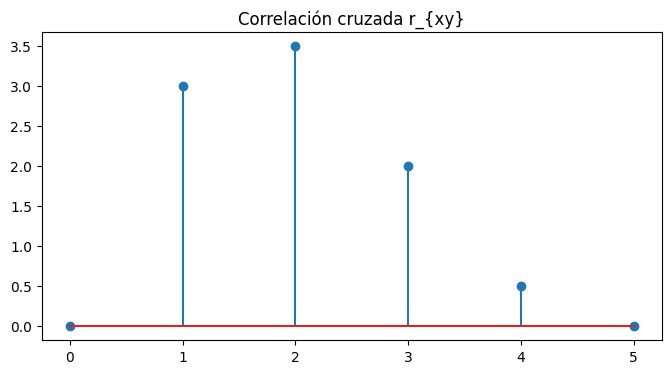

In [52]:
x = np.array([0,1,0.5,0])
y = np.array([1,2,3])
rxy = cc.cross_correlation(x,y)
# correlación mediante convolución con y invertida
y_rev = np.conjugate(y[::-1])
r_via_conv = cc.linear_convolution(x, y_rev)
print('rxy =', rxy)
print('r_via_conv =', r_via_conv)

plt.stem(rxy); plt.title('Correlación cruzada r_{xy}'); plt.show()

## Ejercicios

1) Dado \(x[n] = [1,2,1]\) y \(h[n] = [1,-1]\), calcule la convolución lineal ("full") y la convolución circular con \(N=3\). Explique las diferencias observadas.

2) Compruebe numéricamente que la convolución es conmutativa para señales aleatorias cortas: genere dos vectores aleatorios, calcule \(x*h\) y \(h*x\) y compare con una tolerancia pequeña (p. ej. \(1\times 10^{-12}\)).

3) Compare tiempos: genere dos señales aleatorias de longitud 1024 y compare el tiempo de ejecución entre la implementación directa y la versión por FFT (use \(`time.time()`\) o \(`time.perf_counter()`\).

Sugerencia de entrega: incluye gráficos y comenta las diferencias encontradas (aliasing, tiempos, diferencias numéricas).

## Soluciones (rápidas)
A continuación se muestran las soluciones auto-ejecutables. Puedes ocultar estas celdas si usas el notebook en evaluación.

In [16]:
# Ejercicio 1
x = np.array([1,2,1])
h = np.array([1,-1])
print('lineal:', cc.linear_convolution(x,h))
print('circular N=3:', cc.circular_convolution(x,h))

# Ejercicio 2: conmutatividad
a = np.random.randn(8)
b = np.random.randn(5)
c1 = cc.linear_convolution(a,b)
c2 = cc.linear_convolution(b,a)
print('max abs diff conv(a,b) vs conv(b,a):', np.max(np.abs(c1-c2)))

# Ejercicio 3: tiempos (muy simple)
import time
s1 = np.random.randn(1024)
s2 = np.random.randn(1024)
t0 = time.time(); _ = cc.linear_convolution(s1,s2); t_direct = time.time()-t0
t0 = time.time(); _ = cc.conv_via_fft(s1,s2); t_fft = time.time()-t0
print(f'directa: {t_direct:.6f}s, fft: {t_fft:.6f}s')


lineal: [ 1  1 -1 -1]
circular N=3: [-7.40148683e-17  1.00000000e+00 -1.00000000e+00]
max abs diff conv(a,b) vs conv(b,a): 2.7755575615628914e-17
directa: 0.143135s, fft: 0.000425s
directa: 0.143135s, fft: 0.000425s


## Comparación de implementación local con implementación de numpy

conv_np = [0.  1.  2.5 4.  3.5 2.  0.5]
conv_cc = [0.  1.  2.5 4.  3.5 2.  0.5]
corr_np = [0.5 2.  3.5 4.  2.5 1.  0. ]
corr_cc = [0.5 2.  3.5 4.  2.5 1.  0. ]
corr igual? True


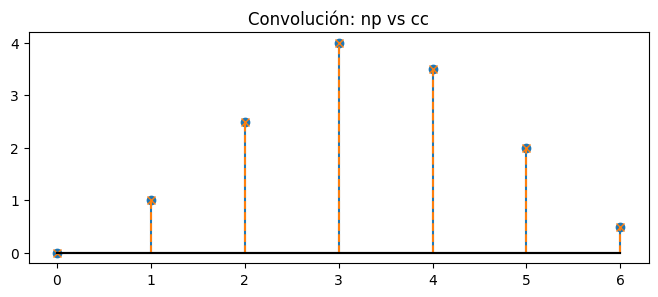

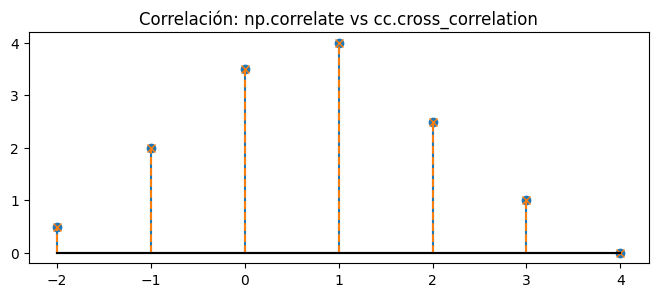

In [58]:
s1 = np.array([1,2,3,2,1])
s2 = np.array([0,1,0.5])

conv_np = np.convolve(s1,s2)
corr_np = np.correlate(s1,s2,mode='full')

conv_cc = cc.linear_convolution(s1,s2)
corr_cc = cc.cross_correlation(s1,s2)

print('conv_np =', conv_np)
print('conv_cc =', conv_cc)
print('corr_np =', corr_np)
print('corr_cc =', corr_cc)
print('corr igual?', np.allclose(corr_np, corr_cc))

plt.figure(figsize=(8,3))
plt.stem(conv_np, linefmt='C0-', markerfmt='C0o', basefmt='k-')
plt.stem(conv_cc, linefmt='C1--', markerfmt='C1x', basefmt='k-')
plt.title('Convolución: np vs cc')
plt.show()

plt.figure(figsize=(8,3))
lags = np.arange(-len(s2)+1, len(s1))
plt.stem(lags, corr_np, linefmt='C0-', markerfmt='C0o', basefmt='k-')
plt.stem(lags, corr_cc, linefmt='C1--', markerfmt='C1x', basefmt='k-')
plt.title('Correlación: np.correlate vs cc.cross_correlation')
plt.show()

In [106]:
# import sounddevice as sd
# from IPython.display import Audio

# sr = 16000
# dur1 = 5.0
# dur2 = 1.5

# fname1 = f'recording_1.wav'
# fname2 = f'recording_2.wav'


# input(f'Presiona Enter para iniciar la grabación de {dur1} segundos...')
# print(f'🎤 Grabando {dur1}s...')
# rec1 = sd.rec(int(dur1 * sr), samplerate=sr, channels=1, dtype='float64')
# sd.wait()
# rec1 = rec1.squeeze()
# cc.save_audio(fname1, rec1, sr, subtype='PCM_16')
# print(f'✅ Grabación {dur1}s guardada: {fname1}')


# display(Audio(rec1, rate=sr))


# input(f'Presiona Enter para iniciar la grabación de {dur2} segundos...')
# print(f'🎤 Grabando {dur2}s...')
# rec2 = sd.rec(int(dur2 * sr), samplerate=sr, channels=1, dtype='float64')
# sd.wait()
# rec2 = rec2.squeeze()
# cc.save_audio(fname2, rec2, sr, subtype='PCM_16')
# print(f'✅ Grabación {dur2}s guardada: {fname2}')

# display(Audio(rec2, rate=sr))


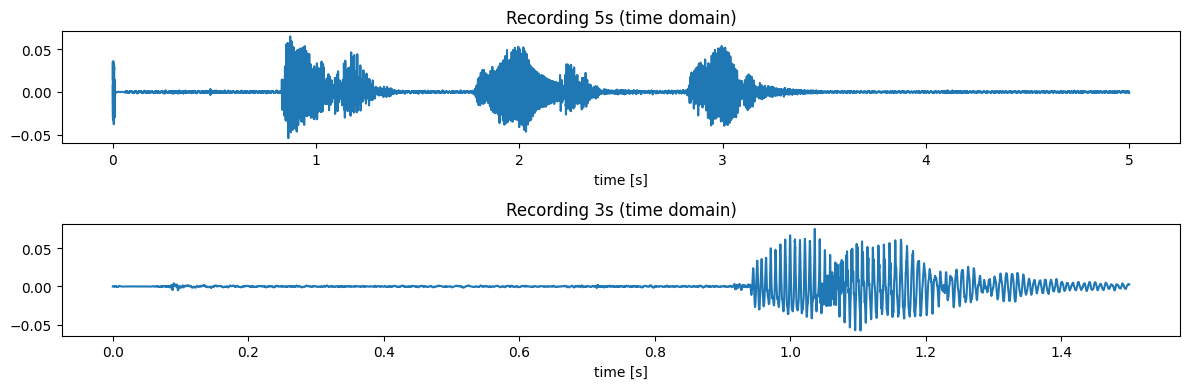

Lag máximo (cross-corr): 13312 muestras, 0.832000 s
Mejor coincidencia: sig3 ≈ sig5[13312:37312]


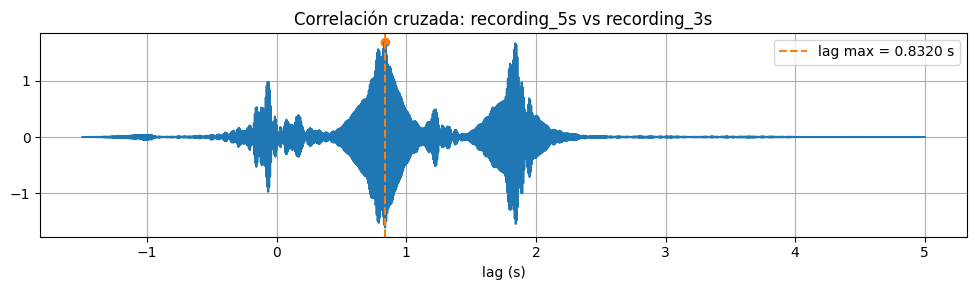

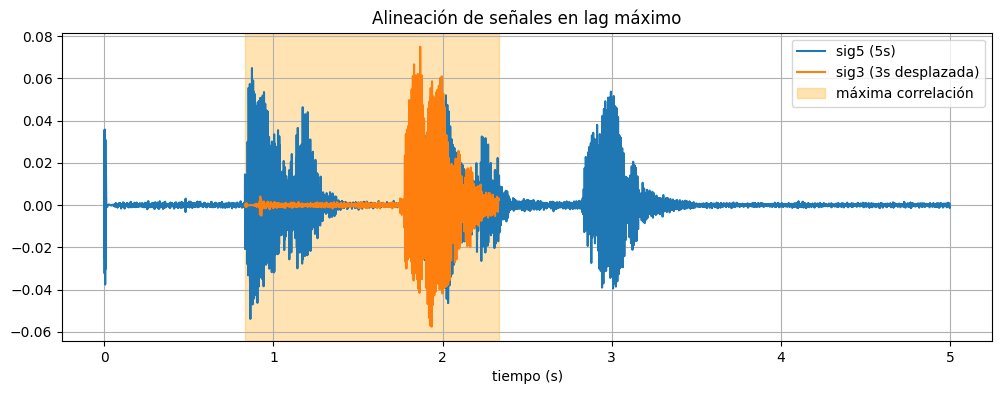

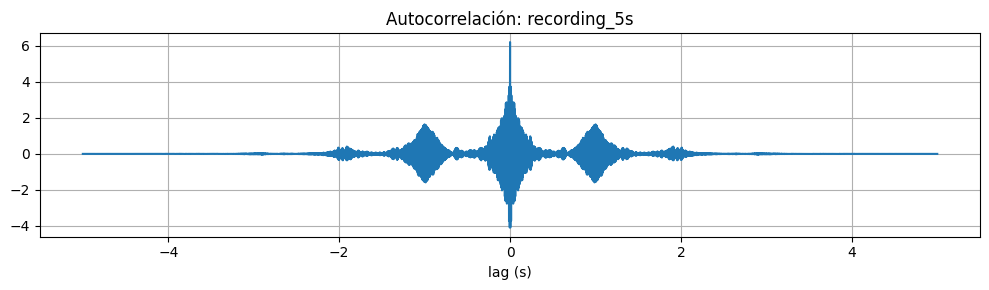

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

fname1 = f'recording_1.wav'
fname2 = f'recording_2.wav'

sig5, sr = cc.read_audio_segment(fname1)
sig3, sr3 = cc.read_audio_segment(fname2)
assert sr == sr3, 'Las tasas de muestreo no coinciden.'

plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(np.arange(sig5.size)/sr, sig5)
plt.title('Recording 5s (time domain)')
plt.xlabel('time [s]')

plt.subplot(2,1,2)
plt.plot(np.arange(sig3.size)/sr, sig3)
plt.title('Recording 3s (time domain)')
plt.xlabel('time [s]')
plt.tight_layout()
plt.show()

r = signal.correlate(sig5, sig3, mode='full')
lags = signal.correlation_lags(len(sig5), len(sig3), mode='full')
lags_s = lags / sr

idx_max = np.argmax(np.abs(r))
lag_samples = lags[idx_max]
lag_seconds = lag_samples / sr
print(f'Lag máximo (cross-corr): {lag_samples} muestras, {lag_seconds:.6f} s')

if lag_samples >= 0:
    start_in_sig5 = lag_samples
    end_in_sig5 = start_in_sig5 + len(sig3)
    print(f"Mejor coincidencia: sig3 ≈ sig5[{start_in_sig5}:{end_in_sig5}]")
else:
    start_in_sig5 = 0
    end_in_sig5 = len(sig3) + lag_samples
    print(f"Mejor coincidencia (lag negativo): sig3[{abs(lag_samples)}:] ≈ sig5[{start_in_sig5}:{end_in_sig5}]")

plt.figure(figsize=(10,3))
plt.plot(lags_s, r)
plt.axvline(lag_seconds, color='C1', linestyle='--', label=f'lag max = {lag_seconds:.4f} s')
plt.scatter([lag_seconds], [r[idx_max]], color='C1')
plt.title('Correlación cruzada: recording_5s vs recording_3s')
plt.xlabel('lag (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('corr_recording_5s_3s.png')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(np.arange(sig5.size)/sr, sig5, label="sig5 (5s)")
plt.plot(np.arange(sig3.size)/sr + lag_seconds, sig3, label="sig3 (3s desplazada)")
plt.axvspan(start_in_sig5/sr, end_in_sig5/sr, color="orange", alpha=0.3, label="máxima correlación")
plt.legend()
plt.title("Alineación de señales en lag máximo")
plt.xlabel("tiempo (s)")
plt.grid(True)
plt.show()

r_auto = signal.correlate(sig5, sig5, mode='full')
lags_auto = signal.correlation_lags(len(sig5), len(sig5), mode='full')
lags_auto_s = lags_auto / sr

plt.figure(figsize=(10,3))
plt.plot(lags_auto_s, r_auto)
plt.title('Autocorrelación: recording_5s')
plt.xlabel('lag (s)')
plt.grid(True)
plt.tight_layout()
plt.savefig('autocorr_recording_5s.png')
plt.show()

Máxima correlación normalizada: 0.688
Desfase estimado: 22790 muestras (1.424 s)


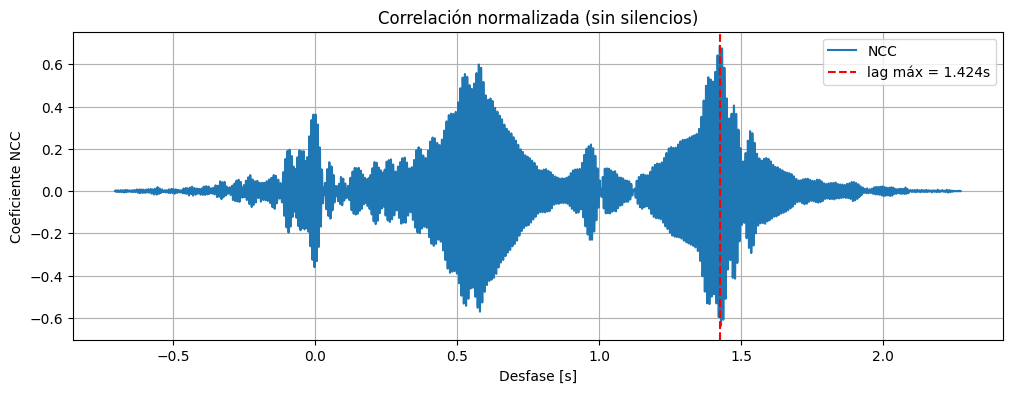

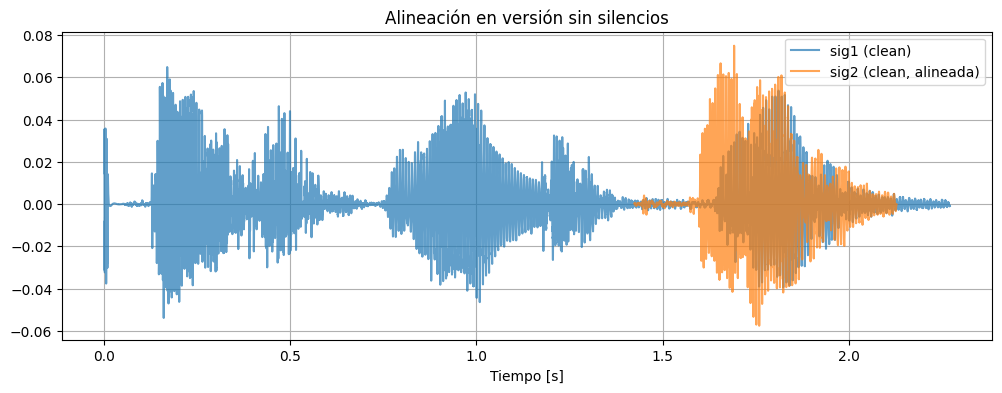

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fname1 = "recording_1.wav"
fname2 = "recording_2.wav"
sig1, sr = cc.read_audio_segment(fname1)
sig2, sr2 = cc.read_audio_segment(fname2)
assert sr == sr2, "Sample rates distintos"

sig1_clean, map1, segs1, energy1, frame_starts1, mask1 = cc.remove_silence_with_map(sig1, sr)
sig2_clean, map2, segs2, energy2, frame_starts2, mask2 = cc.remove_silence_with_map(sig2, sr)

ncc, raw_corr, lags = cc.normalized_cross_correlation(sig1_clean, sig2_clean)
best_idx = np.argmax(ncc)
lag_samples = lags[best_idx]
lag_seconds = lag_samples / sr

print(f"Máxima correlación normalizada: {ncc[best_idx]:.3f}")
print(f"Desfase estimado: {lag_samples} muestras ({lag_seconds:.3f} s)")


plt.figure(figsize=(12,4))
plt.plot(lags/sr, ncc, label="NCC")
plt.axvline(lag_seconds, color="red", linestyle="--", label=f"lag máx = {lag_seconds:.3f}s")
plt.title("Correlación normalizada (sin silencios)")
plt.xlabel("Desfase [s]")
plt.ylabel("Coeficiente NCC")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12,4))
t1 = np.arange(len(sig1_clean))/sr
plt.plot(t1, sig1_clean, label="sig1 (clean)", alpha=0.7)

t2 = np.arange(len(sig2_clean))/sr + (lag_samples/sr)
plt.plot(t2, sig2_clean, label="sig2 (clean, alineada)", alpha=0.7)

plt.title("Alineación en versión sin silencios")
plt.xlabel("Tiempo [s]")
plt.legend()
plt.grid(True)
plt.show()

Señal original


Señal filtrada (promedio móvil)


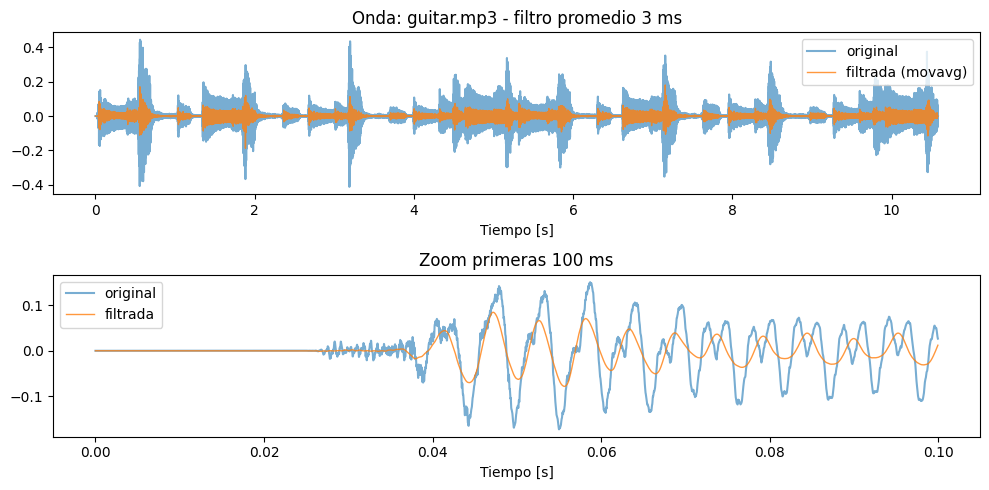

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

window_ms = 3
fname1 = "guitar.mp3"


sig, sr = sf.read(fname1)

if sig.ndim > 1:
    sig_proc = sig[:, 0].astype(float)
else:
    sig_proc = sig.astype(float)

N = max(1, int(window_ms * sr / 1000))
kernel = np.ones(N) / N

sig_filt = np.convolve(sig_proc, kernel, mode='same')

print("Señal original")
display(Audio(sig_proc, rate=sr))

print("Señal filtrada (promedio móvil)")
display(Audio(sig_filt, rate=sr))


t = np.arange(sig_proc.size) / sr

zoom_dur = min(0.1, sig_proc.size / sr)
end_idx = int(zoom_dur * sr)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, sig_proc, alpha=0.6, label='original')
plt.plot(t, sig_filt, alpha=0.8, label='filtrada (movavg)', linewidth=1)
plt.legend()
plt.title(f'Onda: {fname1} - filtro promedio {window_ms} ms')
plt.xlabel('Tiempo [s]')

plt.subplot(2,1,2)
plt.plot(t[:end_idx], sig_proc[:end_idx], alpha=0.6, label='original')
plt.plot(t[:end_idx], sig_filt[:end_idx], alpha=0.8, label='filtrada', linewidth=1)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title(f'Zoom primeras {zoom_dur*1000:.0f} ms')

plt.tight_layout()
plt.show()

# Buffer circular, estilo microcontrolador

🔊 Señal original


🔊 Señal filtrada (promedio móvil, estilo microcontrolador)


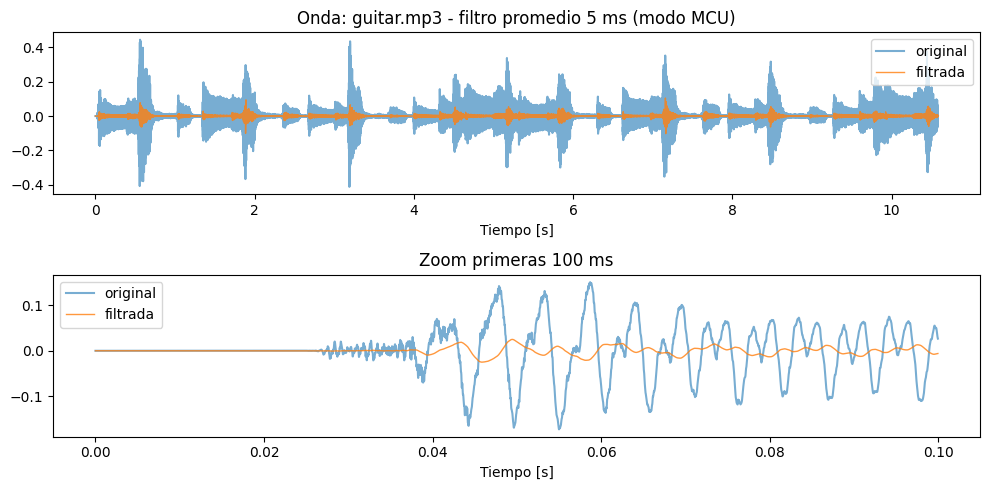

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

window_ms = 5
fname1 = "guitar.mp3"

sig, sr = sf.read(fname1)

if sig.ndim > 1:
    sig_proc = sig[:, 0].astype(float)
else:
    sig_proc = sig.astype(float)

N = max(1, int(window_ms * sr / 1000))

sig_filt = np.zeros_like(sig_proc)
buffer = np.zeros(N)
suma = 0.0
idx = 0

for n, x in enumerate(sig_proc):
    suma -= buffer[idx]
    buffer[idx] = x
    suma += x
    sig_filt[n] = suma / N
    idx = (idx + 1) % N

print("🔊 Señal original")
display(Audio(sig_proc, rate=sr))

print("🔊 Señal filtrada (promedio móvil, estilo microcontrolador)")
display(Audio(sig_filt, rate=sr))

t = np.arange(sig_proc.size) / sr
zoom_dur = min(0.1, sig_proc.size / sr)
end_idx = int(zoom_dur * sr)

plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(t, sig_proc, alpha=0.6, label='original')
plt.plot(t, sig_filt, alpha=0.8, label='filtrada', linewidth=1)
plt.legend()
plt.title(f'Onda: {fname1} - filtro promedio {window_ms} ms (modo MCU)')
plt.xlabel('Tiempo [s]')

plt.subplot(2,1,2)
plt.plot(t[:end_idx], sig_proc[:end_idx], alpha=0.6, label='original')
plt.plot(t[:end_idx], sig_filt[:end_idx], alpha=0.8, label='filtrada', linewidth=1)
plt.legend()
plt.xlabel('Tiempo [s]')
plt.title(f'Zoom primeras {zoom_dur*1000:.0f} ms')

plt.tight_layout()
plt.show()